In [1]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt

In [42]:
class NewsToFuturePriceMapper:
    def __init__(self, news_csv_path, verbose=False, shuffle=True, rows_limit = None):
        self.news_csv_path = news_csv_path
        self.base_url = "https://api.binance.com/api/v3"
        self.session = requests.Session()
        self.verbose = verbose
        self.shuffle = shuffle
        self.rows_limit = rows_limit
        
        self.time_intervals = {
            '1m': 1,
            '5m': 5,
            '30m': 30,
            '1h': 60,
            # '1d': 1440
        }
        
    def load_news_data(self):
        """
        Upload news data from CSV file
        """
        try:
            df = pd.read_csv(self.news_csv_path)

            assert 'date_time' in df.columns, "CSV file must contain 'date_time' column"
            assert 'title' in df.columns, "CSV file must contain 'title' column"

            df['date_time'] = pd.to_datetime(df['date_time'])

            if self.shuffle:
                df = df.drop_duplicates('date_time') # Remove duplicates by date
                df = df.sample(frac=1).reset_index(drop=True)
            
            if self.rows_limit:
                df = df.iloc[:self.rows_limit]

            if self.verbose:
                print(f"Loaded {len(df)} news articles")
                print(f'Shuffle is {self.shuffle}')
                print(f'Rows limit is {self.rows_limit != None}')
            return df
        except Exception as e:
            print(f"Failed to load: {e}")
            return None
    
    def get_kline_at_time(self, symbol, target_time, time_delta=1, interval='1m', limit=1):
        """
        Extracts price at specific time for a given symbol and interval
        
        Args:
            symbol: Ticker 
            target_time: target datetime
            time_delta: time delta to end_time in minutes
            interval: kline interval
            limit: number of klines
        """
        
        start_time = int(target_time.timestamp() * 1000)
        end_time = int((target_time + timedelta(minutes=time_delta)).timestamp() * 1000)
        
        url = f"{self.base_url}/klines"
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': limit
        }
        
        try:
            response = self.session.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if data:
                return float(data[0][4])  # close price
            else:
                return None
                
        except requests.exceptions.RequestException as e:
            if self.verbose:
                print(f"Error for {target_time}: {e}")
            return None
    
    def get_future_prices(self, news_time, symbol='BTCUSDT'):
        """
        Extracts future prices for given time and symbol
        
        Args:
            news_time: datetime
            symbol: Ticker
        """
        future_prices = {}
        
        for interval_name, minutes in self.time_intervals.items():
            future_time = news_time + timedelta(minutes=minutes)
            
            if future_time > datetime.now():
                future_prices[f'price_after_{interval_name}'] = None
                continue
            
            price = self.get_kline_at_time(symbol, future_time)
            future_prices[f'price_after_{interval_name}'] = price
            
            if self.verbose and price:
                print(f"Price after {interval_name} for {news_time}: {price}")
            
            time.sleep(0.001)
        
        return future_prices
    
    def calculate_price_changes(self, current_price, future_price):
        """
        Calculates percentage diff for price
        """
        if future_price and current_price:
            change_percent = round(((future_price - current_price) / current_price) * 100, 2)
        else:
            change_percent = None
        
        return change_percent
    
    def get_current_price(self, news_time, symbol='BTCUSDT'):
        """
        Extracts current price for given symbol
        """
        return self.get_kline_at_time(symbol, news_time)
    
    def process_news_data(self, symbol='BTCUSDT'):
        """
        Main function for processing news data
        """
        news_df = self.load_news_data()
        if news_df is None:
            return None
        
        result_df = news_df.copy()
        
        for interval_name in self.time_intervals.keys():
            result_df[f'price_after_{interval_name}'] = None
            result_df[f'price_change_{interval_name}_percent'] = None
        
        result_df['current_price'] = None
        
        for index, row in result_df.iterrows():
            news_time = row['date_time']
            
            if self.verbose:
                print(f"\n Processing {index + 1}/{len(result_df)}: {news_time}")
                print(f"Title: {row['title'][:50]}...")
            
            current_price = self.get_current_price(news_time, symbol) # Extract current price
            result_df.at[index, 'current_price'] = current_price
            
            future_prices = self.get_future_prices(news_time, symbol)
            
            for col_name, price in future_prices.items():
                result_df.at[index, col_name] = price
            
            for interval_name in self.time_intervals.keys():
                future_price = result_df.at[index, f'price_after_{interval_name}']

                result_df.at[index, f'price_change_{interval_name}_percent'] = self.calculate_price_changes(current_price, future_price)
            
            time.sleep(0.001)
        
        return result_df
    
    def save_results(self, df, filename='news_with_future_prices.csv'):
        """
        Saves results to CSV
        """
        if df is not None:
            os.makedirs('results', exist_ok=True)
            filepath = os.path.join('results', filename)
            
            df.to_csv(filepath, index=False)
            
            if self.verbose:
                print(f"\nSaved to {filepath}")
                print(f"News processed: {len(df)}")
                
                non_null_counts = {}
                for interval_name in self.time_intervals.keys():
                    col_name = f'price_after_{interval_name}'
                    non_null_count = df[col_name].notna().sum()
                    non_null_counts[interval_name] = non_null_count
                
                print("\nStats:")
                for interval, count in non_null_counts.items():
                    print(f"{interval}: {count}/{len(df)} ({count/len(df)*100:.1f}%)")
        else:
            print("No data to save")
    
    def run(self, symbol='BTCUSDT', output_filename='news_with_future_prices.csv'):
        """
        Starts the whole process
        """
        print(f"Started for {symbol} at {datetime.now()}")
        
        result_df = self.process_news_data(symbol)
        
        self.save_results(result_df, output_filename)
        
        return result_df

if __name__ == "__main__":
    # Path to your CSV file with required columns
    news_file_path = "news.csv" # Required columns: date_time, title
    
    mapper = NewsToFuturePriceMapper(news_file_path, verbose=False, rows_limit=1000)
    
    result = mapper.run(symbol='BTCUSDT', output_filename='btc_news_with_future_prices.csv')
    
    if result is not None:
        print("\nData example:")
        print(result[['date_time', 'title', 'current_price', 'price_after_1m', 'price_change_1m_percent']].head())

Started for BTCUSDT at 2025-07-12 16:43:18.850451

Data example:
            date_time                                              title  \
0 2023-12-20 19:11:51  Immutable Hits 20-Month High as Gaming Tokens ...   
1 2024-07-09 08:30:24  Swiss Crypto Bank Amina Partners Pyth Network ...   
2 2018-07-05 17:23:20  Senior Loan ETF an Attractive Option in Rising...   
3 2024-02-20 13:19:00  4 Stocks to Watch as Bitcoin Regains $1 Trilli...   
4 2025-05-04 16:08:35  Bitcoin Price at $95,832: Are Bulls Back After...   

  current_price price_after_1m price_change_1m_percent  
0      44031.32       44058.54                    0.06  
1       57749.9       57694.01                    -0.1  
2       6563.17        6554.99                   -0.12  
3      52263.61       52312.13                    0.09  
4      95507.25       95512.05                    0.01  


In [2]:
result_data = pd.read_csv(r"C:\Users\shari\PycharmProjects\StockPrediction\newsAndPriceMapping\results\btc_news_with_future_prices.csv")
result_data.head()

,Unnamed: 0,date_time,title,article_text,price_after_1m,price_change_1m_percent,price_after_5m,price_change_5m_percent,price_after_30m,price_change_30m_percent,price_after_1h,price_change_1h_percent,current_price
0,143673,2023-12-20 19:11:51,Immutable Hits 20-Month High as Gaming Tokens ...,NaN,44058.54,0.06,44121.23,0.20,43824.32,-0.47,43546.62,-1.10,44031.32
1,153088,2024-07-09 08:30:24,Swiss Crypto Bank Amina Partners Pyth Network ...,NaN,57694.01,-0.10,57714.18,-0.06,57620.01,-0.22,57660.01,-0.16,57749.90
2,39371,2018-07-05 17:23:20,Senior Loan ETF an Attractive Option in Rising...,This article was originally published onETFTre...,6554.99,-0.12,6566.01,0.04,6557.21,-0.09,6569.66,0.10,6563.17
3,88471,2024-02-20 13:19:00,4 Stocks to Watch as Bitcoin Regains $1 Trilli...,The cryptocurrency rally has resumed after a t...,52312.13,0.09,52281.83,0.03,52706.00,0.85,52207.99,-0.11,52263.61
4,179486,2025-05-04 16:08:35,"Bitcoin Price at $95,832: Are Bulls Back After...",NaN,95512.05,0.01,95445.61,-0.06,95351.52,-0.16,95444.17,-0.07,95507.25


In [28]:
intervals = {
    '1m': 1,
    '5m': 5,
    '30m': 30,
    '1h': 60,
}

In [29]:
min_data = result_data['date_time'].min()
max_data = result_data['date_time'].max()
min_data, max_data

('2013-04-11 04:05:17', '2025-05-29 14:59:14')

In [33]:
data_without_news = pd.read_csv(r"C:\Users\shari\PycharmProjects\StockPrediction\train_graph_dataset\BTCUSDT_1m_365days.csv")
data_without_news = data_without_news.loc[:, ['close', 'close_time']]
data_without_news.head()

,close,close_time
0,57939.99,2024-09-04 18:02:59.999
1,57865.00,2024-09-04 18:03:59.999
2,57855.00,2024-09-04 18:04:59.999
3,57812.00,2024-09-04 18:05:59.999
4,57848.01,2024-09-04 18:06:59.999


In [ ]:
for interval_name, minutes in intervals.items():
    step = minutes

    data_without_news[f'price_change_{interval_name}_percent'] = data_without_news['close'].pct_change(step) * 100
data_without_news.sample(20).head()

,close,close_time,price_change_1m_percent,price_change_5m_percent,price_change_30m_percent,price_change_1h_percent
61341,67383.92,2024-10-17 09:24:59.999,-0.035678,-0.068323,-0.118700,0.219152
225471,95923.45,2025-02-08 11:38:59.999,0.000010,-0.033328,-0.155881,-0.246141
486770,116408.92,2025-08-09 02:58:59.999,0.000009,-0.036685,-0.033663,-0.144051
143907,101576.85,2024-12-13 18:52:59.999,-0.005907,-0.033658,0.137415,-0.014588
290905,87301.89,2025-03-25 23:17:59.999,0.031957,0.093889,-0.172676,-0.380588


In [38]:
data_without_news = data_without_news.sample(n=100000, random_state=42).reset_index(drop=True)

In [40]:
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp
import numpy as np
import statsmodels.api as sm

In [41]:
df_random = data_without_news
df_news = result_data

cols_map = {
    "price_change_1m_percent": "price_change_1m_percent",
    "price_change_5m_percent": "price_change_5m_percent",
    "price_change_30m_percent": "price_change_30m_percent",
    "price_change_1h_percent": "price_change_1h_percent"
}

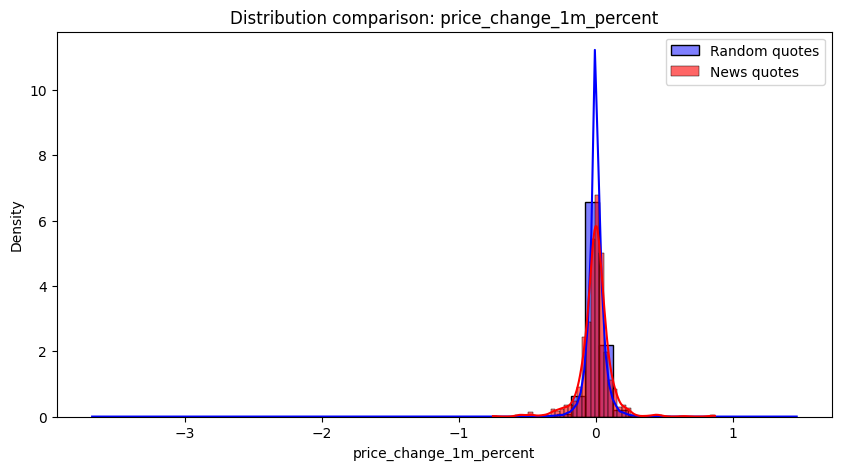

C:\Users\shari\AppData\Local\Temp\ipykernel_13476\1122754103.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[data_random, data_news], palette=["blue","red"])


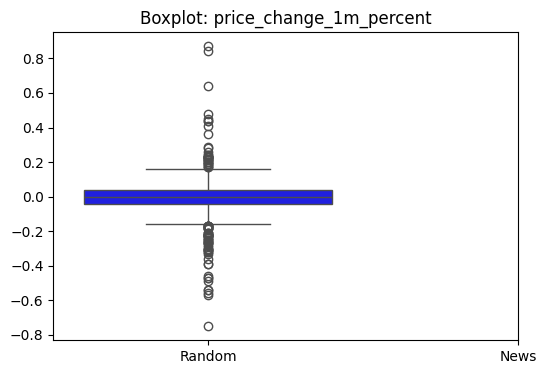

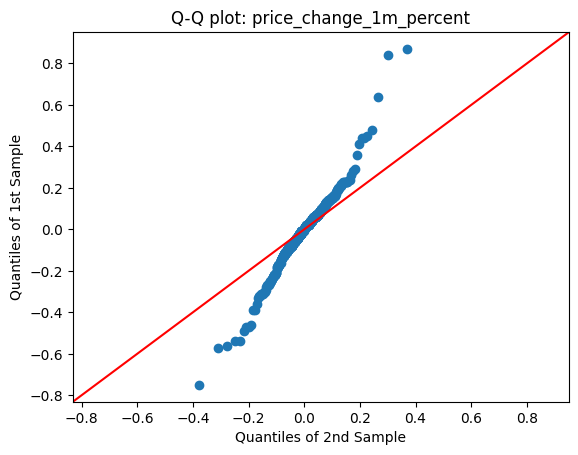

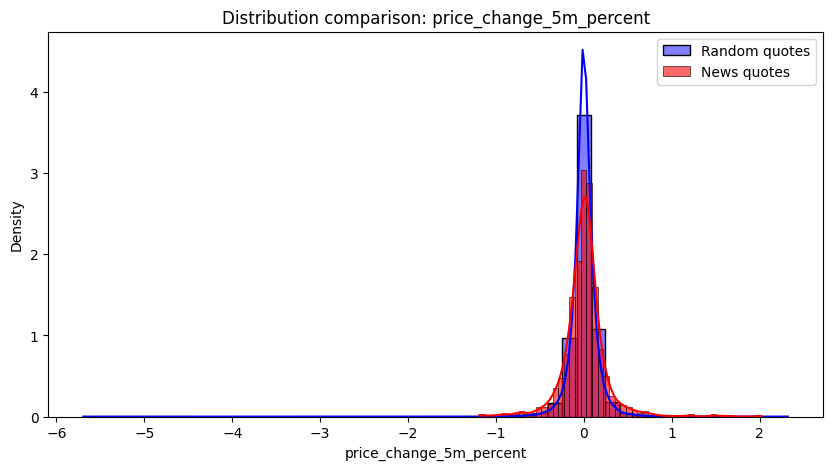

C:\Users\shari\AppData\Local\Temp\ipykernel_13476\1122754103.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[data_random, data_news], palette=["blue","red"])


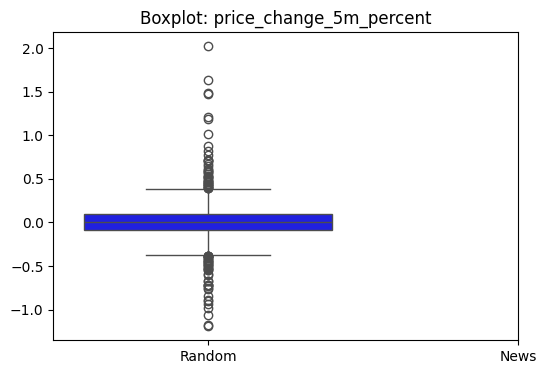

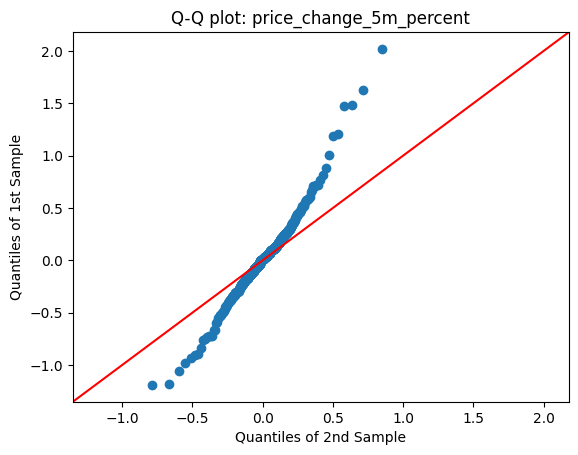

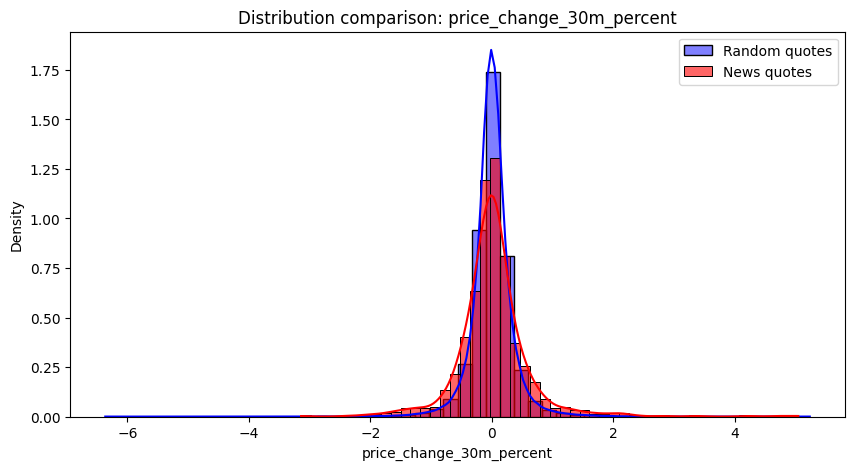

C:\Users\shari\AppData\Local\Temp\ipykernel_13476\1122754103.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[data_random, data_news], palette=["blue","red"])


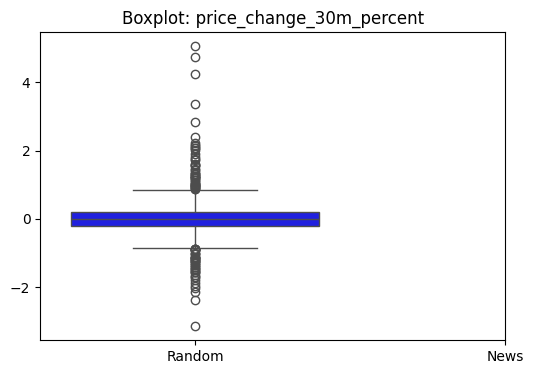

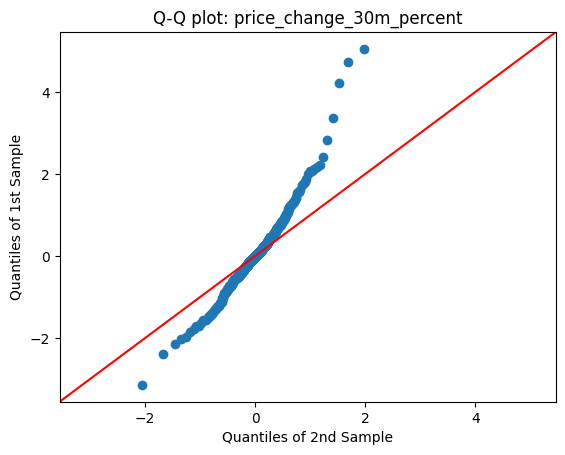

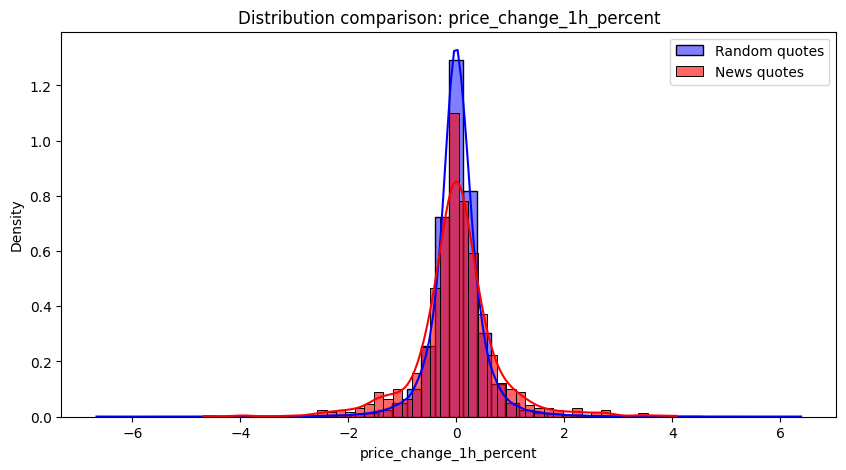

C:\Users\shari\AppData\Local\Temp\ipykernel_13476\1122754103.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[data_random, data_news], palette=["blue","red"])


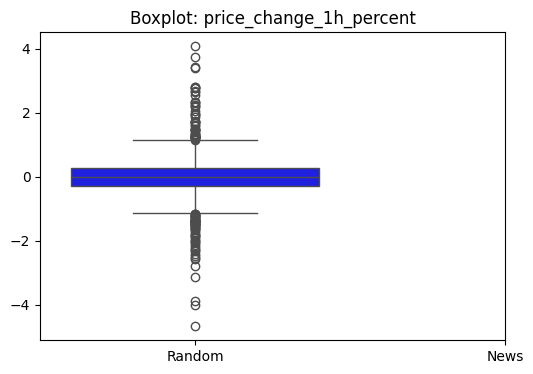

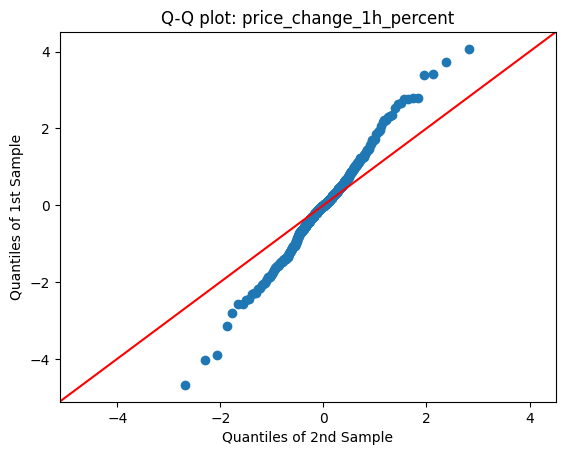

                          mean_random  mean_news  median_random  median_news  \
price_change_1m_percent      0.000057  -0.003032       0.000000         0.00   
price_change_5m_percent      0.001615   0.007050       0.000320         0.01   
price_change_30m_percent     0.004651   0.018272       0.002051         0.00   
price_change_1h_percent      0.009015  -0.006327       0.005514         0.00   

                          std_random  std_news  mannwhitney_stat  \
price_change_1m_percent     0.066251  0.116517        48297355.5   
price_change_5m_percent     0.146434  0.249205        47696425.0   
price_change_30m_percent    0.347617  0.607495        49191166.0   
price_change_1h_percent     0.486850  0.780751        49200967.0   

                          mannwhitney_pvalue   ks_stat     ks_pvalue  
price_change_1m_percent             0.696731  0.110175  1.201949e-10  
price_change_5m_percent             0.292187  0.092080  1.455712e-07  
price_change_30m_percent            0.511568 

In [42]:
results = {}

for col_random, col_news in cols_map.items():
    data_random = df_random[col_random].dropna()
    data_news = df_news[col_news].dropna()
    
    plt.figure(figsize=(10,5))
    sns.histplot(data_random, kde=True, color="blue", label="Random quotes", stat="density", bins=50)
    sns.histplot(data_news, kde=True, color="red", label="News quotes", stat="density", bins=50, alpha=0.6)
    plt.title(f"Distribution comparison: {col_random}")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6,4))
    sns.boxplot(data=[data_random, data_news], palette=["blue","red"])
    plt.xticks([0,1], ["Random", "News"])
    plt.title(f"Boxplot: {col_random}")
    plt.show()

    sm.qqplot_2samples(data_news, data_random, line='45')
    plt.title(f"Q-Q plot: {col_random}")
    plt.show()
    
    mann_res = mannwhitneyu(data_random, data_news, alternative='two-sided')
    ks_res = ks_2samp(data_random, data_news)
    
    stats_summary = {
        "mean_random": np.mean(data_random),
        "mean_news": np.mean(data_news),
        "median_random": np.median(data_random),
        "median_news": np.median(data_news),
        "std_random": np.std(data_random),
        "std_news": np.std(data_news),
        "mannwhitney_stat": mann_res.statistic,
        "mannwhitney_pvalue": mann_res.pvalue,
        "ks_stat": ks_res.statistic,
        "ks_pvalue": ks_res.pvalue
    }
    results[col_random] = stats_summary

results_df = pd.DataFrame(results).T
print(results_df)

In [27]:
from scipy.stats import skew, kurtosis

for col_random, col_news in cols_map.items():
    data_random = df_random[col_random].dropna()
    data_news = df_news[col_news].dropna()
    
    print(f"=== {col_random} ===")
    print("Random skew:", skew(data_random), "News skew:", skew(data_news))
    print("Random kurtosis:", kurtosis(data_random), "News kurtosis:", kurtosis(data_news))


=== price_change_5m_percent ===
Random skew: -0.878389593729081 News skew: 1.0073086729859508
Random kurtosis: 88.97571487527564 News kurtosis: 11.783725770469214
=== price_change_30m_percent ===
Random skew: -0.2667914829296319 News skew: 1.5975593932380312
Random kurtosis: 21.243840953631064 News kurtosis: 13.998394903444463
=== price_change_1h_percent ===
Random skew: -0.13331430595189367 News skew: -0.07110342725475519
Random kurtosis: 15.766127560310977 News kurtosis: 6.021400568018102
